### Run me first

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%reload_ext autoreload
%autoreload 2

con = sqlite3.connect("collca.db")
cur = con.cursor()
#for row in cur.execute('select * from khipu_main'):
    #print(row)

khipuNamesDF = pd.read_sql_query("select KHIPU_ID,INVESTIGATOR_NUM,orig_inv_num, MUSEUM_NAME, MUSEUM_NUM from khipu_main",con)


## Select the khipu you want
#### Input the khipu ID as qID, or use GetKhipuID to search by investigator number

In [2]:
def GetKhipuID (string):
    khipuID = 0
    if len(khipuNamesDF.loc[khipuNamesDF["orig_inv_num"]==string]["KHIPU_ID"]) !=0:
        return khipuNamesDF.loc[khipuNamesDF["orig_inv_num"]==string]["KHIPU_ID"].values[0]
    elif len(khipuNamesDF.loc[khipuNamesDF["INVESTIGATOR_NUM"]==string]["KHIPU_ID"]) !=0:
        return khipuNamesDF.loc[khipuNamesDF["INVESTIGATOR_NUM"]==string]["KHIPU_ID"].values[0]
    else:
        return khipuID;

qID = GetKhipuID('AS1')
string1 = "select pcord_id from primary_cord where khipu_id = "+str(qID)
cur.execute(string1)
pcordID = cur.fetchone()[0]

print(qID)


1000665


## How many cords are in the khipu?


In [3]:

quipuName = khipuNamesDF.loc[khipuNamesDF["KHIPU_ID"]==qID]["orig_inv_num"].values[0]

cordDF = pd.read_sql_query("select * from cord where khipu_ID = "+str(qID),con)
cur = con.cursor()
#get count of pendant cords
string1 = "select count(cord_id) from cord where khipu_id = "+str(qID)+" and cord_level = 1 and cord_classification not like '%T%'"
cur.execute(string1)
countPen = cur.fetchone()[0]
    
#get count of top cords
string1 = "select count(cord_id) from cord where khipu_id = "+str(qID)+" and cord_level = 1 and cord_classification like '%T%'"
cur.execute(string1)
countTop = cur.fetchone()[0]
string1 = "select count(cord_id) from cord where khipu_id = "+str(qID)+" and cord_level = -1"
cur.execute(string1)
countTop += cur.fetchone()[0]
    
#get count of subsidiary cords
string1 = "select count(cord_id) from cord where khipu_id = "+str(qID)+" and cord_level > 1"
cur.execute(string1)
countSubs = cur.fetchone()[0]
string1 = "select count(cord_id) from cord where khipu_id = "+str(qID)+" and cord_level < -1"
cur.execute(string1)
countSubs += cur.fetchone()[0]

toPrint = '{} contains {} pendant cords'.format(quipuName,countPen)
if(countTop!=0):
    toPrint += ' and {} top cords'.format(countTop)
if(countSubs !=0):
    toPrint += ', with {} subsidiary cords'.format(countSubs)
toPrint +='.'
print(toPrint)


AS1 contains 12 pendant cords and 2 top cords, with 17 subsidiary cords.


In [4]:
#Run this cell to set up cord dataframes
cords = pd.read_sql_query("SELECT * FROM CORD WHERE KHIPU_ID = "+str(qID),con)

cords_onlyPendants = cords[cords['PENDANT_FROM']== pcordID]
cords_onlyTops = cords_onlyPendants[cords_onlyPendants['CORD_CLASSIFICATION']=="T"]
cords_onlyPendants = cords_onlyPendants[cords_onlyPendants['CORD_CLASSIFICATION']!="T"]
cords_onlySubs = cords[cords['PENDANT_FROM']!= pcordID]

cords["CORD_NAME"]=""
for index,row in cords.iterrows():
    cordName = ""
    if(row["PENDANT_FROM"]==pcordID):
        #it is attached to primary cord
        cordName = row["INVESTIGATOR_CORD_NUM"]
        if("T" in row["CORD_CLASSIFICATION"]):
            cordName = "T"+str(cordName)
    else:
        #subsidiary cord
        string1 = "select pcord_id from primary_cord where khipu_id = "+str(qID)
        cur.execute(string1)
        pcordID = cur.fetchone()[0]

print(cords.head())



   KHIPU_ID  CORD_ID TWIST_ANGLE THICKNESS FIBER TERMINATION  PENDANT_FROM  \
0   1000665  3059018        None      None  None                   1000664   
1   1000665  3059019        None      None  None                   3059018   
2   1000665  3059020        None      None  None                   1000664   
3   1000665  3059021        None      None  None                   3059020   
4   1000665  3059022        None      None  None                   3059020   

  ATTACHED_TO ATTACHMENT_TYPE  CLUSTER_ID  ...           CHANGED_ON  \
0        None            None     1019850  ...  0000-00-00 00:00:00   
1        None            None     1019854  ...  0000-00-00 00:00:00   
2        None            None     1019850  ...  0000-00-00 00:00:00   
3        None            None     1019855  ...  0000-00-00 00:00:00   
4        None            None     1019855  ...  0000-00-00 00:00:00   

   CORD_LEVEL  CORD_NOTES  TWIST CORD_CLASSIFICATION INVESTIGATOR_CORD_NUM  \
0           1        None 

# Available dataframes
### cords: contains data for all cords in the khipu
### cords_onlyPendants: only contains data for cords attached directly to the primary cord
### cords_onlyTops: only top cords attached to the primary cord
### cords_onlySubs: contains data for subsidiary cords, those attached to pendants or top cords

<AxesSubplot:>

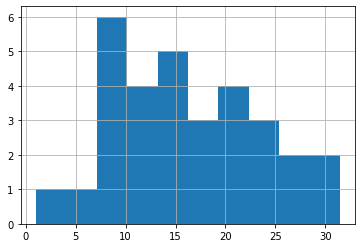

In [5]:
#How long are the cords? Histogram of cord length
cords['CORD_LENGTH'].hist()

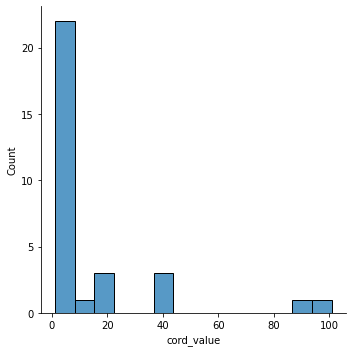

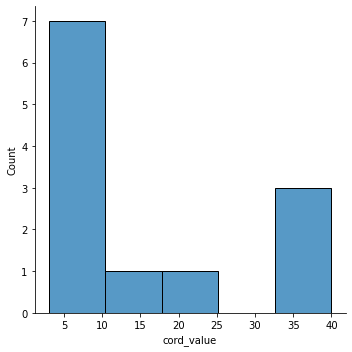

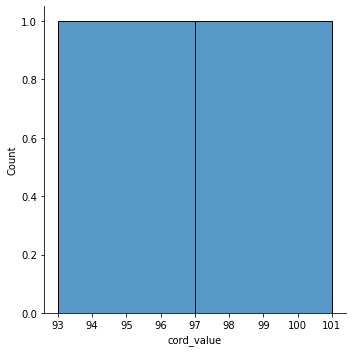

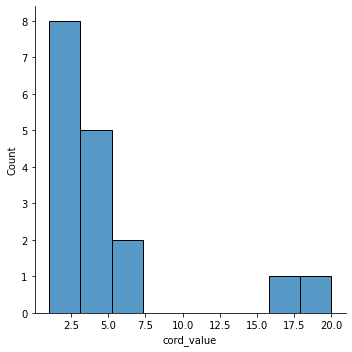

In [6]:
sns.displot(cords['cord_value'])
sns.displot(cords_onlyPendants['cord_value'])
sns.displot(cords_onlyTops['cord_value'])
sns.displot(cords_onlySubs['cord_value'])


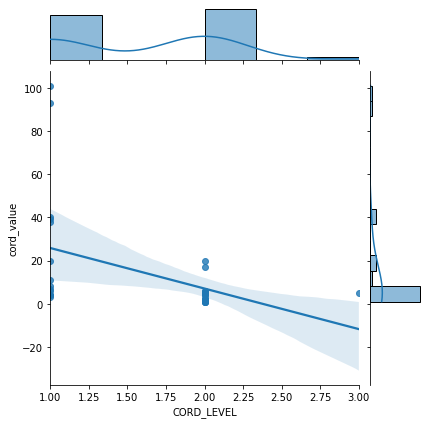

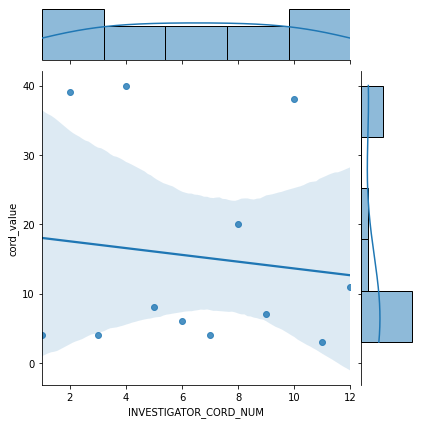

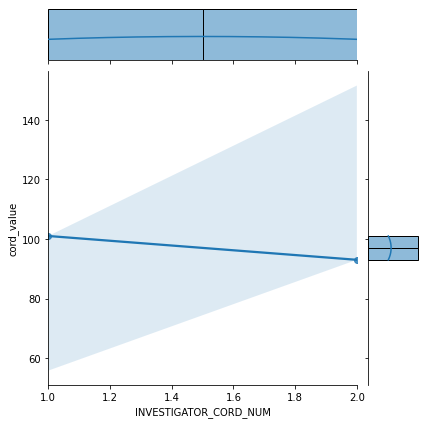

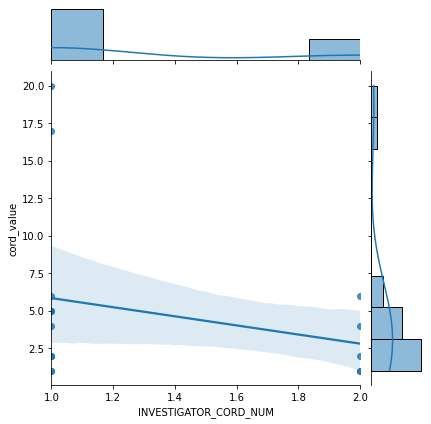

In [7]:
sns.jointplot(x='CORD_LEVEL',y='cord_value',data=cords, kind = 'reg')
sns.jointplot(x='INVESTIGATOR_CORD_NUM',y='cord_value',data=cords_onlyPendants, kind = 'reg')
sns.jointplot( x='INVESTIGATOR_CORD_NUM',y='cord_value',data=cords_onlyTops, kind = 'reg')
sns.jointplot( x='INVESTIGATOR_CORD_NUM',y='cord_value',data=cords_onlySubs, kind = 'reg')


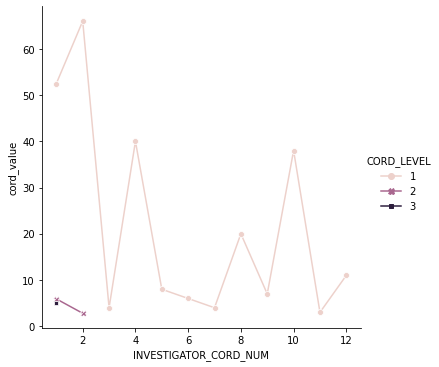

In [8]:
sns.relplot(data=cords,kind='line',y='cord_value',x='INVESTIGATOR_CORD_NUM',markers=True,style='CORD_LEVEL',hue='CORD_LEVEL',dashes=False,ci=None)
plt.show()

In [10]:
cords_onlyPendants.head()

,KHIPU_ID,CORD_ID,TWIST_ANGLE,THICKNESS,FIBER,TERMINATION,PENDANT_FROM,ATTACHED_TO,ATTACHMENT_TYPE,CLUSTER_ID,...,CHANGED_BY,CHANGED_ON,CORD_LEVEL,CORD_NOTES,TWIST,CORD_CLASSIFICATION,INVESTIGATOR_CORD_NUM,CANUTO_ORDINAL,CANUTO_ID,cord_value
0,1000665,3059018,None,None,None,,1000664,None,None,1019850,...,None,0000-00-00 00:00:00,1,None,None,,1,None,None,4
2,1000665,3059020,None,None,None,,1000664,None,None,1019850,...,None,0000-00-00 00:00:00,1,None,None,,2,None,None,39
5,1000665,3059023,None,None,None,,1000664,None,None,1019850,...,None,0000-00-00 00:00:00,1,None,None,,3,None,None,4
7,1000665,3059025,None,None,None,,1000664,None,None,1019850,...,None,0000-00-00 00:00:00,1,None,None,,4,None,None,40
10,1000665,3059028,None,None,None,,1000664,None,None,1019850,...,None,0000-00-00 00:00:00,1,None,None,,5,None,None,8
